# Preprocess Images
This notebook includes further preprocessing (face extraction, PCA) of the face images for predictive modeling.

---

### Content:

- **1) Load Packages & Data**
- **2) Extract Faces**
- **3) PCA on Faces** (for SVM)
    - a) Convert images to grayscale
    - b) Flatten images
    - c) Perform PCAs
    - d) Plot principal compontents
    - e) Reconstruct faces from principal compontents
---

# 1) Load Packages & Data

In [2]:
# load basic packages

import pandas as pd
import numpy as np
import os, os.path

import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use('seaborn-white')  
sns.set_style("white")

In [3]:
# load padded and squared images

data_path = '/Users/kacha/nf-ds/nf_capstone/data/'
Xs = np.load(data_path + 'Xs.npy')
Xs_public = np.load(data_path + 'Xs_public.npy')

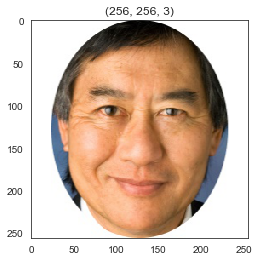

In [14]:
# display one example image (with publication-friendly data)

idx = 12
plt.imshow(Xs_public[idx])
plt.title(Xs_public[idx].shape);

---
# 2) Extract Faces

In [4]:
# get tools for face extraction

#!pip install mtcnn
#!pip install tensorflow

from mtcnn import MTCNN
from PIL import Image

Using TensorFlow backend.


In [15]:
# write function to extract face using the MTCNN Face Detection Tool (potentially distorts the face)
# see: https://github.com/ipazc/mtcnn

def extract_face(image_array, target_size=(224, 224)):

    # bring image array in correct format (0-255)
    image_array = (image_array*255).astype('uint8')
    max_height = image_array.shape[0]
    max_width = image_array.shape[1]

    # create the detector, using default weights
    detector = MTCNN()
 
    # detect faces in the image
    results = detector.detect_faces(image_array)
  
    # extract the bounding box from the first face (ensure positive result)
    x1, y1, width, height = results[0]['box']
    #print(x1, y1, width, height)

    x1_n = max(0, x1)
    y1_n = max(0, y1)
    width_n = width - abs(x1-x1_n)
    height_n = height - abs(y1-y1_n)

    x2, y2 = x1_n + width_n, y1_n + height_n
    #print(x1_n, y1_n, width_n, height_n)

    x2_n = min(max_width, x2)
    y2_n = min(max_height, y2)
    #print(x2, y2, x2_n, y2_n)

    # extract the face
    face = image_array[y1_n:y2_n, x1_n:x2_n]

    # resize pixels to the model size
    image = Image.fromarray(face).resize(target_size)
    face_array = np.asarray(image) / 255.

    return face_array

In [16]:
# write function to extract face using the MTCNN Face Detection Tool (without distorting the face)

def extract_face_without_distortion(image_array, target_size=(224, 224)):

    # bring image array in correct format (0-255)
    image_array = (image_array*255).astype('uint8')
    max_height = image_array.shape[0]
    max_width = image_array.shape[1]

    # create the detector, using default weights
    detector = MTCNN()
 
    # detect faces in the image
    results = detector.detect_faces(image_array)
  
    # extract the bounding box from the first face (ensure positive result)
    x1, y1, width, height = results[0]['box']
    #print(x1, y1, width, height)

    x_center = x1 + width/2
    y_center = y1 + height/2
    
    size = max(width, height)
    x1_new = int(x_center - size/2)
    y1_new = int(y_center - size/2)
    
    x2_new = int(x_center + size/2)
    y2_new = int(y_center + size/2)
    
    x1_corr = max(0, x1_new)
    y1_corr = max(0, y1_new)
    
    x2_corr = min(x2_new, max_width)
    y2_corr = min(y2_new, max_height)    

    # extract the face
    face = image_array[y1_corr:y2_corr, x1_corr:x2_corr]

    # resize pixels to the model size
    image = Image.fromarray(face).resize(target_size)
    face_array = np.asarray(image) / 255.

    return face_array

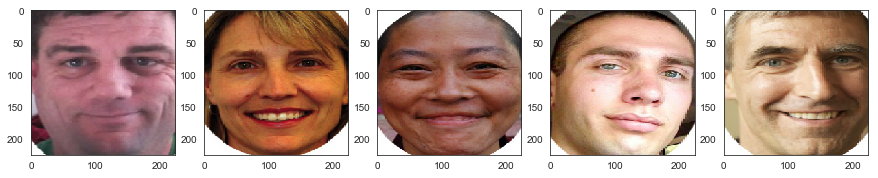

In [18]:
# demonstrate face extraction for 5 images (with distortion due to resizing)

n_img = 5
target_size = (224, 224)

fig = plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    face = extract_face(Xs_public[i], target_size)
    plt.imshow(face);

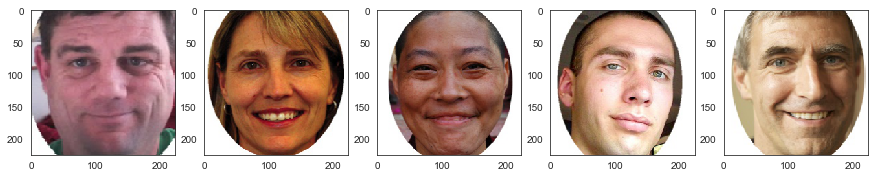

In [19]:
# demonstrate face extraction for 5 images (with distortion)

fig = plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    face = extract_face_without_distortion(Xs_public[i], target_size)
    plt.imshow(face);

In [21]:
# write functions to create new image array with extracted faces for modeling

def extract_all_faces(X, target_size):
    n_img = len(X)
    X_faces = np.zeros((n_img, target_size[0], target_size[1], 3))

    for i in range(n_img):
        print("\r", "Progress {:2.1%}".format((i+1) / n_img), end="")
        X_faces[i] = extract_face(X[i], target_size)

    return X_faces

def extract_all_faces_without_distortion(X, target_size):
    n_img = len(X)
    X_faces = np.zeros((n_img, target_size[0], target_size[1], 3))

    for i in range(n_img):
        print("\r", "Progress {:2.1%}".format((i+1) / n_img), end="")
        X_faces[i] = extract_face_without_distortion(X[i], target_size)

    return X_faces

In [7]:
# apply face extraction functions to whole dataset

target_size = (224, 224)

Xf = extract_all_faces(Xs, target_size)
np.save('/Users/kacha/nf-ds/nf_capstone/data/Xf.npy', Xf)

Xf2 = extract_all_faces_without_distortion(Xs, target_size)
np.save('/Users/kacha/nf-ds/nf_capstone/data/Xf2.npy', Xf2)

Xf.shape, Xf2.shape

 Progress 100.0%

(2222, 224, 224, 3)

In [22]:
# do the same for publication-friendly images for demonstration

target_size = (224, 224)

Xf_public = extract_all_faces(Xs_public, target_size)
np.save('/Users/kacha/nf-ds/nf_capstone/data/Xf_public.npy', Xf_public)

Xf2_public = extract_all_faces_without_distortion(Xs_public, target_size)
np.save('/Users/kacha/nf-ds/nf_capstone/data/Xf2_public.npy', Xf2_public)

Xf_public.shape, Xf_public.shape

 Progress 98.0%

((49, 224, 224, 3), (49, 224, 224, 3))

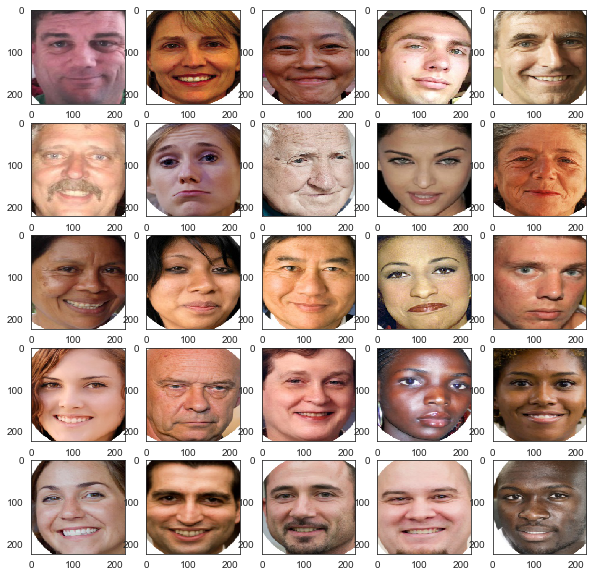

In [24]:
# check extracted faces with publication-friendly data

# with distortions
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(Xf_public[i]);

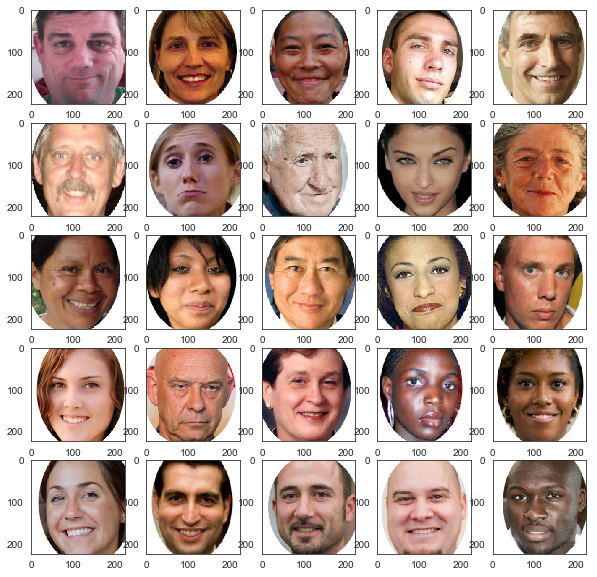

In [25]:
# without distortions
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(Xf2_public[i]);

---
# 3) PCA on Faces (for SVM)

### a) Convert images to grayscale

In [28]:
# load data if starting notebook from here

#Xf = np.load('/Users/kacha/nf-ds/nf_capstone/data/Xf.npy')
#Xf_public = np.load('/Users/kacha/nf-ds/nf_capstone/data/Xf_public.npy')

In [26]:
# write function to convert rgb images to grayscale
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
# https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert

def rgb2gray(X):
    return np.dot(X[...,:3], [0.2989, 0.5870, 0.1140])

In [29]:
# convert images to grayscale

Xfg = rgb2gray(Xf)
Xfg_public = rgb2gray(Xf_public)
Xfg.shape, Xfg_public.shape

((2222, 224, 224), (49, 224, 224))

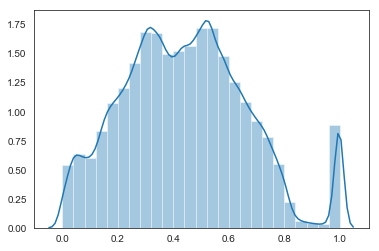

In [32]:
# plot distribution of pixel values for grayscale images

sns.distplot(Xfg[:10].ravel(), bins=25);

### b) Flatten images

In [33]:
# flatten rgb image arrays for PCA
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

Xf_flat = Xf.reshape((Xf.shape[0], -1))
Xf_flat_public = Xf_public.reshape((Xf_public.shape[0], -1))
Xf_flat.shape, Xf_flat_public.shape

((2222, 150528), (49, 150528))

In [34]:
# flatten grayscale image arrays for PCA
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

Xfg_flat = Xfg.reshape((Xfg.shape[0], -1))
Xfg_flat_public = Xfg_public.reshape((Xfg_public.shape[0], -1))
Xfg_flat.shape, Xfg_flat_public.shape

((2222, 50176), (49, 50176))

### c) Perform PCAs

In [67]:
# Option 1: PCA on rgb images
from sklearn.decomposition import PCA

pca_Xf = PCA(n_components=0.95, svd_solver='auto', whiten=True, random_state=0) 
pca_Xf.fit(Xf_flat)
print(pca_Xf.n_components_)

311


In [35]:
# Option 2: PCA on grayscale images

pca_Xfg = PCA(n_components=0.95, svd_solver='auto', whiten=True, random_state=0) 
pca_Xfg.fit(Xfg_flat)
print(pca_Xfg.n_components_)

257


### d) Plot principal compontents

In [49]:
# write function to plot the principal components
# https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.EVj3DDhy.dpuf

def plot_principal_components(pca, channels):
    
    height = 224   # 256
    width = 224    # int(pca.n_features_/height/channels)
    
    fig = plt.figure(figsize=(width/20,height/20))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # left=0, right=1, bottom=0, top=1, 

    for i in range(100): 
        ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[]) 
        if channels==1:
            img = np.reshape(pca.components_[i,:], (height,width))
            ax.imshow(img,cmap=plt.cm.gray, interpolation='nearest')
        elif channels==3:
            from sklearn.preprocessing import MinMaxScaler
            mm = MinMaxScaler()
            img_flat = mm.fit_transform(pca.components_[i,:].reshape(-1, 1)) 
            img = np.reshape(img_flat, (height,width,channels))
            ax.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


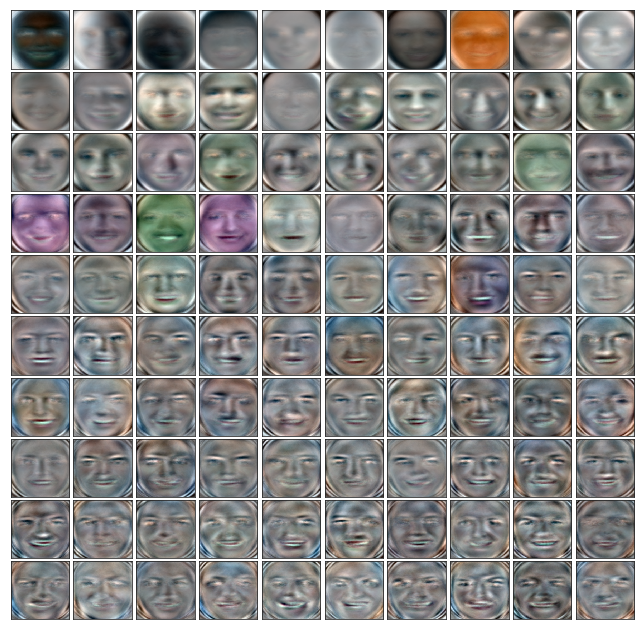

In [71]:
# plot principal compontents for rgb images
plot_principal_components(pca_Xf, channels=3)

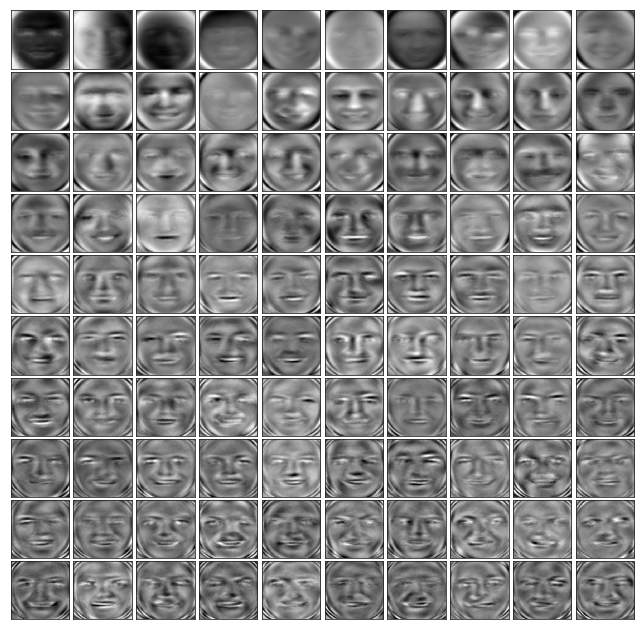

In [50]:
# plot principal compontents for grayscale images
plot_principal_components(pca_Xfg, channels=1)

### e) Reconstruct faces from principal compontents

In [68]:
# Write function to reconstruct the images from principal compontents
# Therefore, we need to inverse transform the reduced images back to the original dimensions. 
# see: https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.EVj3DDhy.dpuf

def plot_reconstructed_images(pca, X_flat, channels, n_subplots=49):
    
    # inverse transform (flat) image arrays
    X_proj = pca.transform(X_flat)
    X_inv_proj = pca.inverse_transform(X_proj) 

    # reshaping to original dimensions 
    height = 224  # 256
    width = 224   # int(pca.n_features_/height/channels)
 
    if channels==1:
        X_proj_img = np.reshape(X_inv_proj,(-1,height,width))
    elif channels==3:
        from sklearn.preprocessing import MinMaxScaler
        mm = MinMaxScaler()
        X_proj_img_flat = mm.fit_transform(X_inv_proj) 
        X_proj_img = np.reshape(X_proj_img_flat, (-1,height,width,channels))

    # plot reconstructed images 
    fig = plt.figure(figsize=(width/20,height/20))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)  # left=0, right=1, bottom=0, top=1,
    for i in range(n_subplots): 
        ax = fig.add_subplot(np.sqrt(n_subplots),np.sqrt(n_subplots), i+1, xticks=[], yticks=[]) 
        if channels==1:
            ax.imshow(X_proj_img[i], cmap=plt.cm.gray, interpolation='nearest') 
        elif channels==3:
            ax.imshow(X_proj_img[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

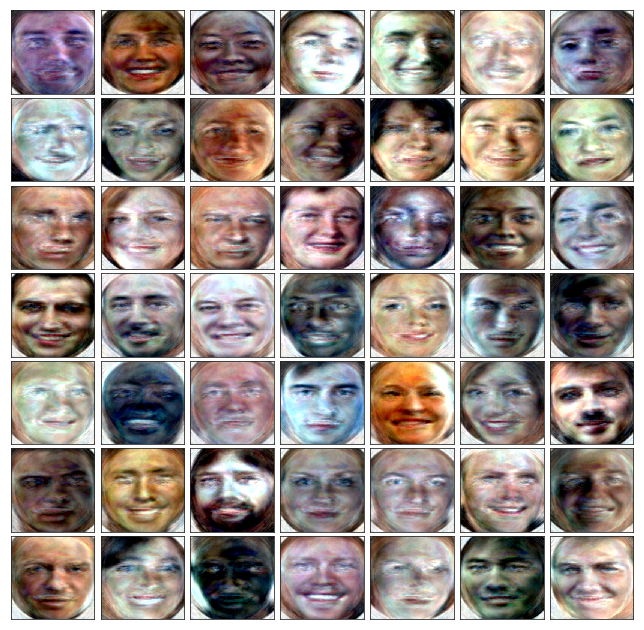

In [69]:
# plot reconstructed faces for rgb images (use publication-friendly images for demonstration)
plot_reconstructed_images(pca_Xf, Xf_flat_public, channels=3)

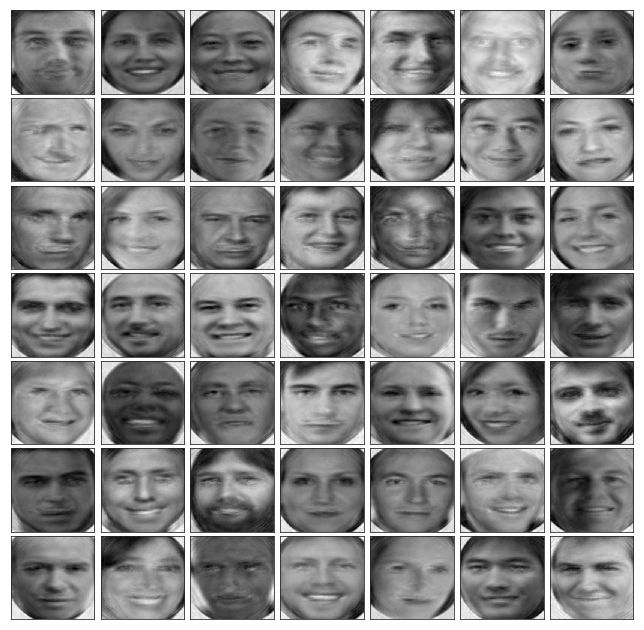

In [70]:
# plot reconstructed faces for grayscale images (use publication-friendly images for demonstration)
plot_reconstructed_images(pca_Xfg, Xfg_flat_public, channels=1)